In [28]:
# READ RADAR DATA
import numpy as np
import cmaps
import matplotlib
import matplotlib.pyplot as plt

cfile='/data/ra000007/zhaoyang/postprocess/jp_pawr/data/pawr/radar_20210730060100.dat'

dtype=np.dtype('>f') ### big endian float
# dtype=np.dtype('<f') ### little endian float

vread=np.fromfile(cfile,dtype=dtype)

vlon_radar=vread[1]
vlat_radar=vread[4]
vz_radar=vread[7]
print(vlon_radar,vlat_radar,vz_radar)
# read site info

nrec=7 
# nrec=8 ### radar-4d

ioffset=9

ndata=int((len(vread)-ioffset)/(nrec+2))
print(ndata)

vdata=np.zeros(shape=(ndata,nrec))
# 2D-0: obs variable
# 2D-1: longitude (degree)
# 2D-2: latitude (degree)
# 2D-3: vertical level (hPa or m)
# 2D-4: obs value
# 2D-5: obs error std
# 2D-6: obs type

for i in range(ndata):
  ista=i*(nrec+2)+1+ioffset
  iend=i*(nrec+2)+nrec+1+ioffset
  vdata[i,:]=vread[ista:iend]

lon = np.array(vdata[:,1])
lat = np.array(vdata[:,2])
hgt = np.array(vdata[:,3])
val = np.array(vdata[:,4])

del vdata,vread,ndata
  

139.60898 35.8615 29.3
833616


-9.999734935773422
54.7266993823349


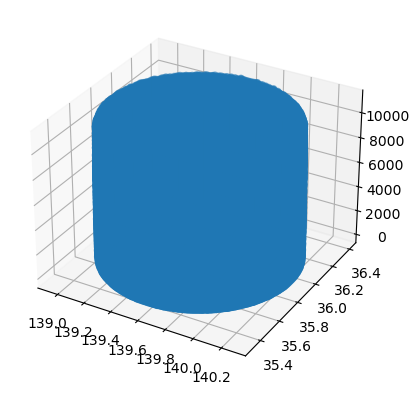

In [29]:

# QC VALUE
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

fillvalue = 0.1
val[val < 0.1] = fillvalue
val = [10 * np.log10(num) if num != fillvalue else num for num in val]
print(np.min(val))
print(np.max(val))

ax.scatter(lon, lat, hgt)

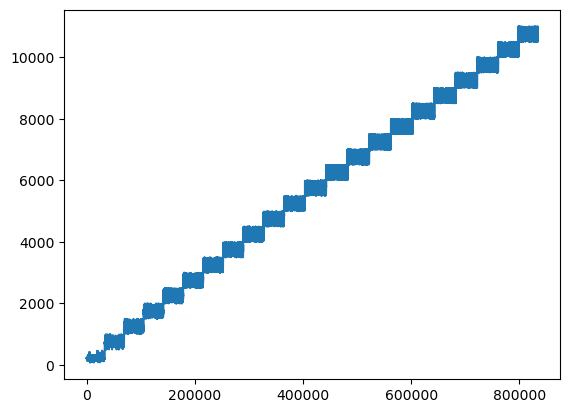

In [30]:
fig = plt.figure()
ax = fig.add_subplot()

lev_ind = []
for i in range(1,len(lat)):
    if(lat[i]-lat[i-1]<-0.5):
        lev_ind.append(i)

lev = 1
# ax.plot(hgt[lev_ind[lev-1]:lev_ind[lev]])
ax.plot(hgt)


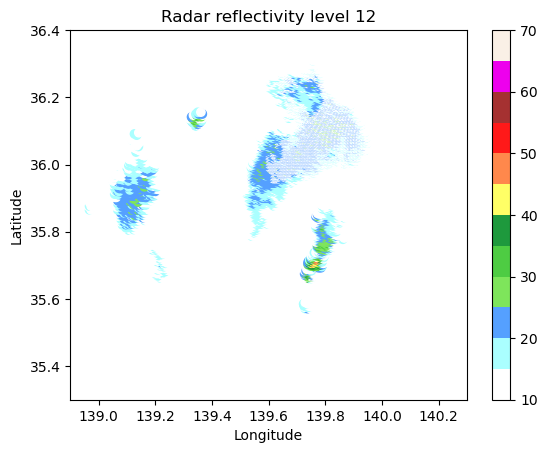

In [31]:
lev = 12
lon_lev = lon[lev_ind[lev-1]:lev_ind[lev]]
lat_lev = lat[lev_ind[lev-1]:lev_ind[lev]]
val_lev = val[lev_ind[lev-1]:lev_ind[lev]]

lon_lev, lat_lev, val_lev = zip(*((i,j,k) for i,j,k in \
                        zip(lon_lev,lat_lev,val_lev) if (k>5) ))

cmap=cmaps.prcp_1
levels= matplotlib.ticker.MaxNLocator(nbins=12).tick_values(10,70)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
plt.scatter(lon_lev, lat_lev, c=val_lev, cmap=cmap, norm=norm)


plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(138.9, 140.3)
plt.ylim(35.3, 36.4)
plt.title('Radar reflectivity level '+str(lev))
plt.show()

# del lon_lev,lat_lev,val_lev,lev_ind

In [32]:
# RESHAPE TO CAPPI
import math

lonmax = math.ceil(np.max(lon)*10)/10
lonmin = int(np.min(lon)*10)/10

latmax = math.ceil(np.max(lat)*10)/10
latmin = int(np.min(lat)*10)/10

lon_target = np.arange(lonmin,lonmax,0.005)
lat_target = np.arange(latmin,latmax,0.005)
hgt_target = np.arange(2000,2500,1000)

# lon_target = np.arange(139.5,140.0,0.005)
# lat_target = np.arange(35.5,36.0,0.005)
# hgt_target = np.arange(1000,2000,1000)

x_t, y_t, z_t = np.meshgrid(lon_target, lat_target, hgt_target)

lon, lat, hgt, val = zip(*((i,j,k,l) for i,j,k,l in zip(lon,lat,hgt,val) if (l>0)))

# Interpolation 
cappi = np.zeros_like(z_t,dtype=float)
print(np.shape(cappi))
for HH in range(np.shape(hgt_target)[0]):
    print('HH=',HH)
    y_l=y_t[:,:,HH].flatten()
    x_l=x_t[:,:,HH].flatten()
    z_l=z_t[:,:,HH].flatten()
    cappi_lev = np.zeros_like(z_l,dtype=float)
    try:
        lon_a, lat_a, hgt_a, val_a = zip(*((i,j,k,l) for i,j,k,l in zip(lon,lat,hgt,val) if (abs(k-hgt_target[HH])<800)))
    except ValueError:
        cappi[:,:,HH]=cappi_lev
        continue
    for i in range(len(cappi_lev)):
        ilon = x_l[i]
        ilat = y_l[i]
        ihgt = z_l[i]
        try:
            obs_x, obs_y, obs_v = zip(*((i,j,k) for i,j,k in \
                            zip(lon_a,lat_a,val_a) if ((abs(i-ilon)<0.003) & (abs(j-ilat)<0.003))))
        except ValueError:
            continue
        else:
            cappi_lev[i]= np.mean(obs_v)
    cappi_lev = cappi_lev.reshape([np.shape(z_t)[0],np.shape(z_t)[1]])
    cappi[:,:,HH]=cappi_lev

    del cappi_lev,x_l,y_l,z_l,lon_a,lat_a,hgt_a,val_a,obs_x,obs_y,obs_v
    
    


(221, 281, 1)
HH= 0


(221, 281, 1)


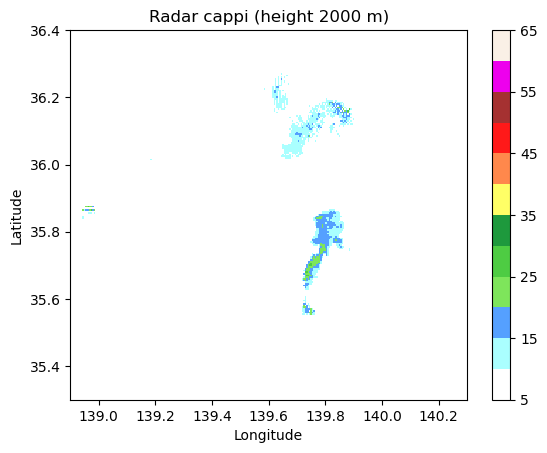

In [33]:
cappi = cappi.reshape([np.shape(z_t)[0],np.shape(z_t)[1],np.shape(z_t)[2]])
print(np.shape(cappi))

# fig = plt.figure(figsize=(10, 8), dpi=200)
# ax = fig.add_subplot(111)

cmap=cmaps.prcp_1
levels= matplotlib.ticker.MaxNLocator(nbins=12).tick_values(5,65)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
mdbz = np.amax(cappi, axis=2)
h=0
plt.pcolormesh(x_t[:,:,0], y_t[:,:,0], cappi[:,:,h], cmap=cmap, norm=norm,)
plt.colorbar()#fraction=0.035, pad=0.04)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(138.9, 140.3)
plt.ylim(35.3, 36.4)
plt.title('Radar cappi (height '+str(hgt_target[h])+' m)')

# Show the plot
plt.show()